
Maths for including a spatial correlations in the optical wave inversion algorithm
$$
F = F_0 + \mathbf{k}\mathbf{u}\cdot dt +\varepsilon
$$
$$
F -  F_0  = \Delta \phi =\mathbf{k}\mathbf{u}\cdot dt +\varepsilon
$$

$$
\mathbf{y} = \mathbf{H}\mathbf{x}+\varepsilon
$$

where

$$
\mathbf{y} = 
\begin{bmatrix}
	\begin{bmatrix}
	\Delta \phi_{11}\\ \vdots \\ \Delta \phi_{1k} 
	\end{bmatrix}
	\\
	\vdots \\
	\begin{bmatrix}
	\Delta \phi_{s1}\\ \vdots \\ \Delta \phi_{sk}
	\end{bmatrix}
\end{bmatrix}
$$

is the observed phase lag, $\Delta \phi_{sk}$, at each spatial location for each (coherent) wavenumber.

- $k$ - wavenumber index
- s - space index
- Size $[N\times 1]$. ($N$ is the total number of observations, number of spatial points times the number of coherent wavenumbers)

$$
\mathbf{H} = 
\begin{bmatrix}
	\begin{bmatrix}
	h_{11u} &  h_{11v} \\ \vdots & \vdots\\ 
	h_{1ku} &  h_{1kv}
	\end{bmatrix}
	& 0
	\\
	0 &
	\begin{bmatrix}
	h_{s1u} &  h_{s1v} \\ \vdots & \vdots\\ 
	h_{sku} &  h_{skv}
	\end{bmatrix}
\end{bmatrix}
$$
is the "operator" matrix i.e. the linear operator to go from model to observations. For wave inversion  $h_{sku} = \mathbf{k}_k\ dt$   at location $s$.  

Size  $[2 \times S]$.
$$
\mathbf{x} = 
\begin{bmatrix}
	\begin{bmatrix}
	u_{1}\\  v_{1}
	\end{bmatrix}
	\\
	\vdots \\
	\begin{bmatrix}
	u_{s}\\ v_{s}
	\end{bmatrix}
\end{bmatrix}
$$
contains the velocity estimates.

The solution of $\mathbf{x}$ is (OI formula):

$$
\mathbf{x} = \mathbf{B}\mathbf{H}^T \left(\mathbf{H} \mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{y}
$$
and the variance of the conditional distribution is:
$$
V[\mathbf{x}|\mathbf{y}] = \mathbf{B}\ - \mathbf{B}\mathbf{H}^T \left(\mathbf{H} \mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}\mathbf{H}\mathbf{B}
$$
The model covariance matrix $\mathbf{B}$ is

$$
\mathbf{B}\equiv V[\mathbf{x}] = V[\mathbf{x_s}] 
\otimes
V[\mathbf{x_{uv}}]
$$

- $V[\mathbf{x}_s]$ - is the spatial covariance matrix. Size $[S\times S]$. (Probably use general Matern).
- $V[\mathbf{x_{uv}}]$ - is the covariance between harmonics. Size $[2\times 2]$. (Probably just identity matrix $I$).

The error covariance matrix $\mathbf{R}$ is
$$
\mathbf{R}\equiv V[\mathbf{\varepsilon}] = V[\varepsilon_s] 
\otimes
V[\varepsilon_k]
$$
- $V[\varepsilon_s]$ - is the spatial error covariance matrix. Size $[S\times S]$
- $V[\varepsilon_k]$ - is the wavenumber error covariance. Size $[K \times K]$.

Initially set
$$
\mathbf{R} = \sigma^2\mathbf{I}
$$
where size $\mathbf{I}= [N\times N]$.



In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42921")
client

<Client: 'tcp://127.0.0.1:42921' processes=4 threads=4, memory=15.62 GiB>

In [2]:
from scipy import sparse 
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt

import sparse as dasksparse
from dask import array as da

from gptide import cov

In [8]:
# ds = xr.open_dataset('../../../DATA/49HGE_nativem_uv.nc')
# ds = xr.open_dataset('../../../DATA/49HGE_nativem_uv_128.nc')
# ds = xr.open_dataset('../../../DATA/49HGE_nativem_uv_bias.nc')
# ds = xr.open_dataset('../../../DATA/49KGR_nativem_uv_bias.nc')

basedir = '../RPSLinkage/DATA/20240127'
# basedir = '../RPSLinkage/DATA/20240421'
ds = xr.open_dataset(f'{basedir}/49KGR_10m_uv_bias_512.nc')

ds

<xarray.Dataset>
Dimensions:        (Y: 21, X: 21, p: 2, nperseg: 64, granule_n: 512)
Coordinates:
  * Y              (Y) float64 7.597e+06 7.592e+06 ... 7.5e+06 7.495e+06
  * X              (X) float64 7.025e+05 7.076e+05 ... 7.998e+05 8.049e+05
  * p              (p) int64 0 1
  * nperseg        (nperseg) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Dimensions without coordinates: granule_n
Data variables: (12/17)
    u              (Y, X) float64 ...
    v              (Y, X) float64 ...
    e              (Y, X) float64 ...
    bias           (Y, X) float64 ...
    dt             (Y, X) float64 ...
    n              (Y, X) float64 ...
    ...             ...
    residuals      (Y, X, nperseg, nperseg) float64 ...
    rhs            (Y, X, nperseg, nperseg) float64 ...
    granule_0_grd  (Y, X, granule_n, granule_n) float64 ...
    granule_1_grd  (Y, X, granule_n, granule_n) float64 ...
    kx             (nperseg, nperseg) float64 ...
    ky             (nperseg, nperseg) float64 ...
Attributes: (12/17)
    chunk:                     49KGR
    resolution_m:              10
    sensing_date_unix:         20240127T024311
    z1:                        49
    z2:                        K
    band_timing_nbar_band_02:  4.7
    ...                        ...
    band_timing_nbar_band_07:  6.5
    band_timing_nbar_band_12:  6.8
    export_filename:           /mnt/c/Users/00071913/OneDrive - The Universit...
    Lmin:                      10
    Lmax:                      200
    dx:                        10

In [20]:
# Spatial B kernel input parameters
η = 0.5 # m/s
ℓ_x = 5e3 # m
ℓ_y = 5e3

# IID noise
noise = 0.001

# Coherence threshold
threshold = 0.97 # 0.8
Lmin = 50
Lmax = 300
F0max = 20

bias = True

In [21]:
def phase_shift(F_bar, coh_bar, kx, ky, dt,
               coherence_threshold,
               Lmin, Lmax, F0max):
    # Compute the phase shift
    g=9.81
    depth=5000.
    K = np.abs(kx+1j*ky)
    L = 2*np.pi/K

    F0 = np.abs(dt)*np.sqrt(g*K*np.tanh(K*depth)) # Phase shift = dt*omega 
    F_F0_bar = np.abs(F_bar)-F0
    
    valid_points2 = F_bar<0 
    valid_points2 = valid_points2 & \
        (np.abs(F_F0_bar)*180/np.pi < F0max) 

    valid_points2 = valid_points2 \
        & (L>Lmin) & (L<Lmax)

    valid_points  = np.abs(coh_bar) > coherence_threshold
    valid_points2 = valid_points2 & valid_points

    return F_F0_bar, valid_points2

In [22]:

Hlist = []
ylist = []
XYlist = []
for ii in range(ds.dims['X']):
    for jj in range(ds.dims['Y']):
        coh = ds['coh_bar'][jj,ii,...].values
        F_bar = ds['F_bar'][jj,ii,...].values
        dt = ds['dt'][jj,ii].values
        kx, ky = ds['kx'].values , ds['ky'].values

        dphi, idx = phase_shift(F_bar, coh, kx, ky, dt,
                               threshold,
                               Lmin, Lmax, F0max)

        #if np.sum(idx)>0:   
        if bias:
            ones = np.ones_like(kx[idx])
            H = np.array([ones, kx[idx], ky[idx]]).T
        else:
            H = np.array([kx[idx], ky[idx]]).T
            
        Hlist.append(H)

        #ylist.append([dphi[idx]])
        ylist.append([-dphi[idx]]) #???

        XYlist.append([ds['X'][ii].values, ds['Y'][jj].values])
        


/tmp/ipykernel_1985414/3039556388.py:8: RuntimeWarning: divide by zero encountered in divide
  L = 2*np.pi/K


In [23]:
Nobsold = np.hstack(ylist).shape[1]
Nobsold

13434

In [24]:
# Append a dummy point so that we can have square chunks (cholesky needs this)
chunksize=2000
nextra = chunksize - Nobsold%chunksize

ydummy = 1e-7 * np.ones((nextra,))

if bias:
    Hdummy = 1e-7 * np.ones((nextra,3)) # with bias
else:
    Hdummy = 1e-7 * np.ones((nextra,2))
Hlist.append(Hdummy)
ylist.append([ydummy])
XYlist.append([XYlist[-1]])

In [25]:
y = np.hstack(ylist).T
X = np.vstack(XYlist)
X.shape, y.shape

((442, 2), (14000, 1))

In [26]:
H = sparse.block_diag(Hlist).tocsc()
Nobs = y.shape[0]
H, y.shape, Nobs

(<14000x1326 sparse matrix of type '<class 'numpy.float64'>'
 	with 42000 stored elements in Compressed Sparse Column format>,
 (14000, 1),
 14000)

In [27]:
Hs = dasksparse.COO.from_scipy_sparse(H)
Hs

Format,coo
Data Type,float64
Shape,"(14000, 1326)"
nnz,42000
Density,0.0022624434389140274
Read-only,True
Size,656.2K
Storage ratio,0.00


In [82]:
# Build "B" and "R" matrices
def matern32_2d(x, xpr, params):
    """
    2D kernel

    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale

    """
    eta, lx, ly = params

    # Build the covariance matrix
    C  = cov.matern32(x[:,1,None], xpr[:,1,None].T, ly)
    C *= cov.matern32(x[:,0,None], xpr[:,0,None].T, lx)
    C *= eta**2

    return C


In [83]:
covfunc = matern32_2d
####

Bs = covfunc(X, X, (η, ℓ_x, ℓ_y))


if bias:
    Bm = sparse.eye(3) # with bias
else:
    Bm = sparse.eye(2)

# B = sparse.kron(Bm, Bs).tocsc()
B = sparse.kron(Bs, Bm).tocsc()

Bs = dasksparse.COO.from_scipy_sparse(B)
Bs

Format,coo
Data Type,float64
Shape,"(5295, 5295)"
nnz,9345675
Density,0.3333333333333333
Read-only,True
Size,142.6M
Storage ratio,0.67


In [84]:
Hd = da.from_array(Hs, chunks=chunksize)
Hd

dask.array<array, shape=(4000, 5295), dtype=float64, chunksize=(2000, 2000), chunktype=sparse.COO>

In [85]:
Bd = da.from_array(Bs, chunks=chunksize)
Bd

dask.array<array, shape=(5295, 5295), dtype=float64, chunksize=(2000, 2000), chunktype=sparse.COO>

In [86]:
yd = da.from_array(y, chunks=chunksize)
yd

dask.array<array, shape=(4000, 1), dtype=float64, chunksize=(2000, 1), chunktype=numpy.ndarray>

In [87]:
# IID noise "R" matrix
N = y.shape[0]
R = noise*sparse.eye(N).tocsc()

Rs = dasksparse.COO.from_scipy_sparse(R)
Rd = da.from_array(Rs, chunks=chunksize)
Rd

dask.array<array, shape=(4000, 4000), dtype=float64, chunksize=(2000, 2000), chunktype=sparse.COO>

In [88]:
# Linear algebra time
BHt = Bd@Hd.T
HBHt_R = Hd@BHt + Rd
HBHt_R
# linalg routines require dense matrices...
HBHt_R_dense = da.map_blocks(dasksparse.COO.todense, HBHt_R)
HBHt_R_dense

dask.array<todense, shape=(4000, 4000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [89]:
# Cholesky solve (faster)
L = da.linalg.cholesky(HBHt_R_dense, lower=True)
v = da.linalg.solve_triangular(L, yd, lower=True)
HBHt_R_1_y = da.linalg.solve_triangular(L.T, v, lower=False)
x_ = BHt @ HBHt_R_1_y


In [90]:
%%time
x_ = x_.compute()

/home/jupyter-mrayson/.local/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 17.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 60 ms, sys: 130 ms, total: 190 ms
Wall time: 10.2 s


In [91]:

if bias:
    outbias = x_[0::3]
    u = x_[1::3]
    v = x_[2::3]
else:
    u = x_[0::2]
    v = x_[1::2]



2.8113432840210852


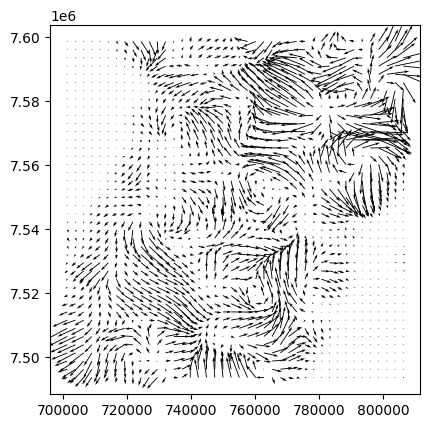

In [92]:
plt.figure()
ax=plt.subplot(111)
plt.quiver(X[:,0], X[:,1], u, v, scale_units='xy', scale=2e-4)
ax.set_aspect('equal')
speed = np.abs(u+1j*v)
print(speed.max())

-0.04425254421183847

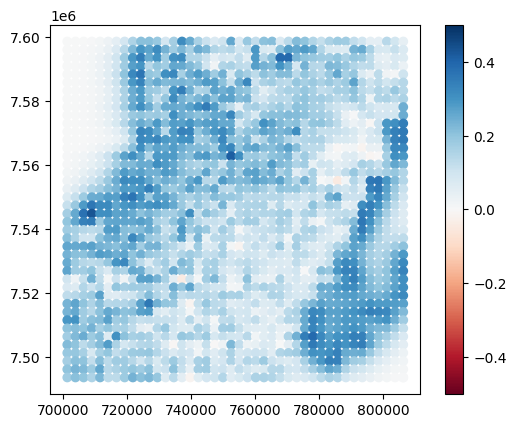

In [93]:
plt.figure()
ax=plt.subplot(111)
plt.scatter(X[:,0], X[:,1], c=outbias, cmap='RdBu',vmin=-0.5, vmax=0.5)
ax.set_aspect('equal')
plt.colorbar()
outbias.min()

<xarray.DataArray ()>
array(0.7623168)

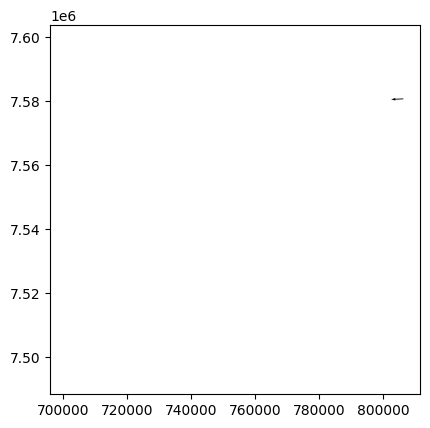

In [47]:
plt.figure()
# ax=plt.subplot(121)
# plt.quiver(X[:,0], X[:,1], u, v, scale_units='xy', scale=2e-4)
# ax.set_aspect('equal')
# speed = np.abs(u+1j*v)
# print(speed.max())

# ax2=plt.subplot(122, sharex=ax, sharey=ax)
ax2=plt.subplot(111)
plt.quiver(ds['X'], ds['Y'], ds['u'], ds['v'], scale_units='xy', scale=2e-4)
ax2.set_aspect('equal')
speed = np.abs(ds['u'] +1j * ds['v'])
speed.max()